In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

### Imports

In [2]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

<IPython.core.display.Javascript object>

### Dataset Overview:

Dataset from kaggle: https://www.kaggle.com/shubhamsarafo/advertising 


The dataset consists of __1000 observations__ and __10 columns__. This data set contains the following features:


| Column Name   | Description                                               |
| ------------- |:-------------                                            :| 
| Daily Time Spent on Site           |Amount of time in the website by the customer (in minutes)                                                  | 
| Age      | Age of the customer                        |  
| Area Income        | Avg. Income of geographical area of consumer                                           | 
| Daily Internet Usage          | Daily average time spent on the internet by the customer (in minutes)                                        |   
| Ad Topic Line           | Headline of the advertisement                                          |
| City           | City of the customer                                       |
| Male         | Indicates whether the customer is male or not (1 - Male; 0 - Female)  |
| Country         | Country of the customer  |
| Timestamp         | Time at which customer clicked on Ad or closed window  |
| Clicked on Ad         | 0 or 1  (1 indicated clicking on Ad)|


### Uploading and Cleaning Data

In [3]:
# read imported data from: https://www.kaggle.com/shubhamsarafo/advertising

ad_df = pd.read_csv("data/advertising.csv")
ad_df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,3/27/16 0:53,0
1,80.23,31,68441.85,193.77,Monitored national standardization,Boe,1,Nauru,4/4/16 1:39,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,3/13/16 20:35,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,1/10/16 2:31,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,6/3/16 3:36,0


<IPython.core.display.Javascript object>

In [4]:
ad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.2+ KB


<IPython.core.display.Javascript object>

Based on this information, none of the columns have null values, and while 3 of the column entries are integer values, and 3 are floating numbers, 4 of the column entries are categorical in nature. Now, I will inspect the number of unique entries for each column to get a better sense of the data.

In [5]:
# check if there are duplicated records
ad_df.duplicated().sum()

0

<IPython.core.display.Javascript object>

In [6]:
# check how many unique countries are
ad_df["Country"].nunique()

237

<IPython.core.display.Javascript object>

In [7]:
# check how many unique cities are
ad_df["City"].nunique()

969

<IPython.core.display.Javascript object>

In [8]:
# check how many unique Ads are
ad_df["Ad Topic Line"].nunique()

1000

<IPython.core.display.Javascript object>

In [9]:
ad_df["Clicked on Ad"].value_counts()

1    500
0    500
Name: Clicked on Ad, dtype: int64

<IPython.core.display.Javascript object>

Dataset is perfect balanced

The dataset is very clean, no missing values or duplicates so we can proceed with exploratory data analysis.

### Exploratory Data Analysis

* Visualizing relations between nimerical features and label

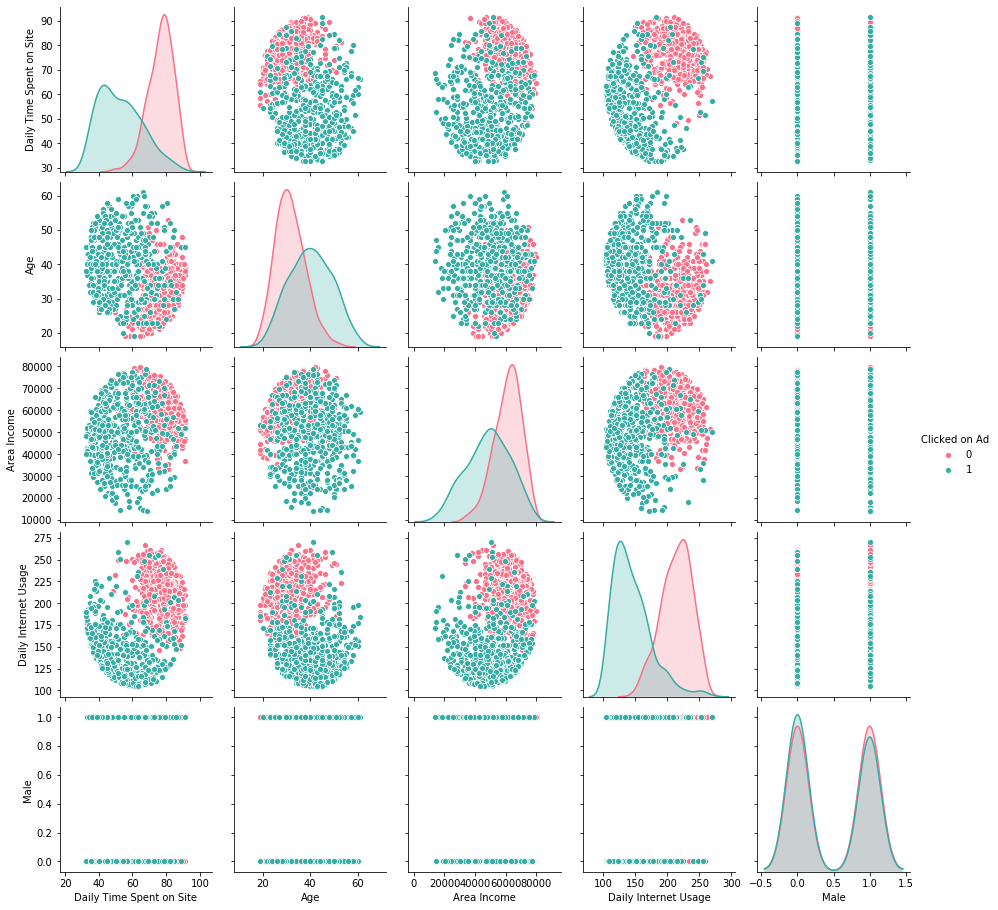

<IPython.core.display.Javascript object>

In [10]:
sns.pairplot(ad_df, hue="Clicked on Ad", palette="husl")

Customers who have clicked on the ad are:
* older, with an average around 40 years old
* those who spent less time browsing the internet and who spent less time on the site
* from regions with a lower average income

Females clicked on ads a bit more than males.

There is a relatively good separation between our classes which will make our predictions more accurate.

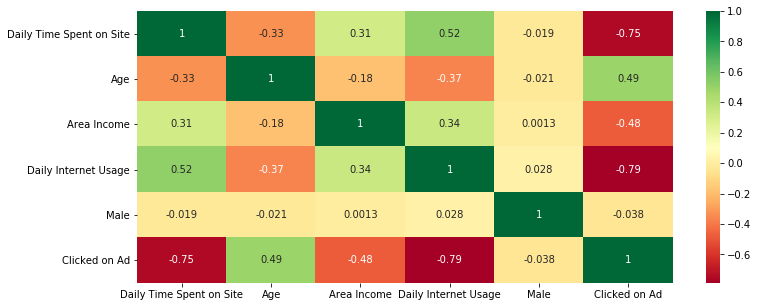

<IPython.core.display.Javascript object>

In [11]:
plt.figure(figsize=(12, 5))
# sns.heatmap(df.corr(), annot=True)
sns.heatmap(ad_df.corr(), cmap="RdYlGn", annot=True)
plt.show()

From the heat map looks like the best predictors for Clicking on the ad would be Daily Time Spent on Site and Daily Internet Usage.

### Feature Selection and Engineering

* Let's investigate the categorical features:

There are 1000 unique ads, so encoding these would be near impossible using One Hot Encode, so let's check most common words

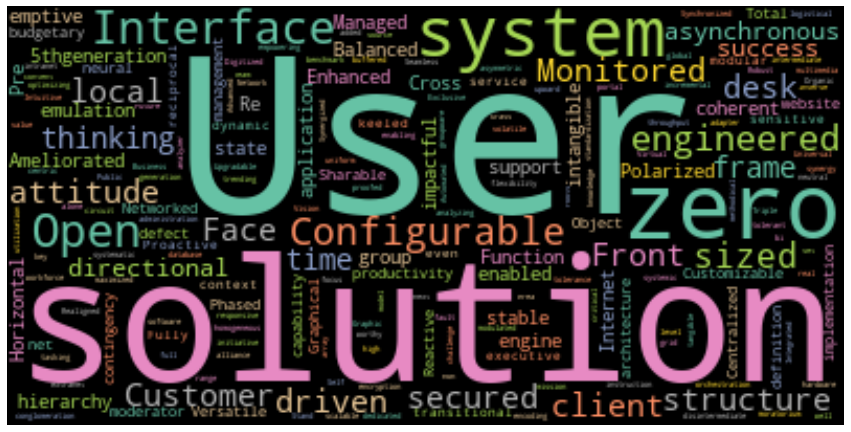

<IPython.core.display.Javascript object>

In [12]:
stopwords = set(STOPWORDS)
stopwords.update(["Multi", "based", "focused", "oriented", "line"])

wordcloud = WordCloud(
    random_state=1,
    background_color="black",
    colormap="Set2",
    collocations=False,
    stopwords=stopwords,
).generate(" ".join(ad_df["Ad Topic Line"]))

plt.figure(figsize=(15, 10))
# Display the generated image

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

No useful information regarding the Topic Line of the Ads

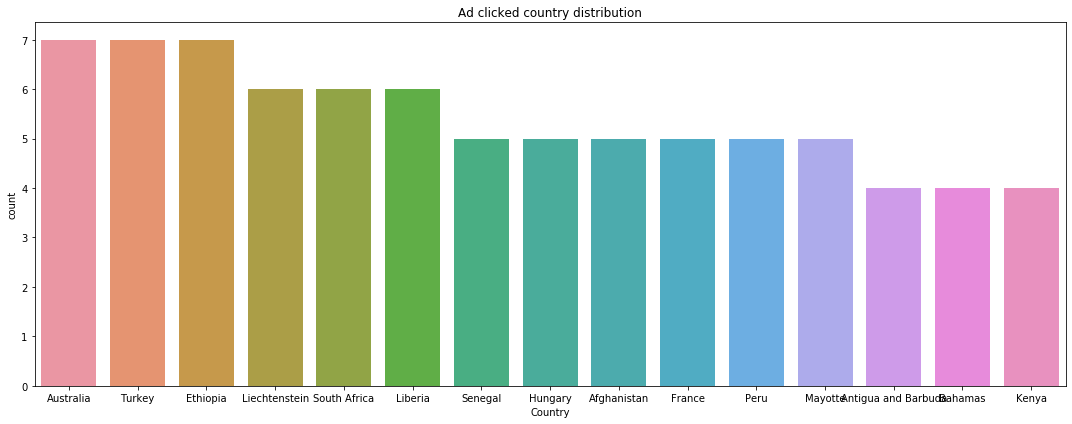

<IPython.core.display.Javascript object>

In [13]:
# Distribution of top 15 country's ad clicks
plt.figure(figsize=(15,6))
sns.countplot(x='Country',data=ad_df[ad_df['Clicked on Ad']==1],order=ad_df[ad_df['Clicked on Ad']==1]['Country'].value_counts().index[:15])

plt.title('Ad clicked country distribution')
plt.tight_layout()


No useful information regarding the customer's country of origin.

Similar for the customer's City.

In [14]:
# Changeing the datetime object
ad_df["Timestamp"] = pd.to_datetime(ad_df["Timestamp"])

# Extracting Timestamp to generate new columns as Month, Day, Hour and Weekday
ad_df["Weekday"] = ad_df["Timestamp"].dt.dayofweek
ad_df["Hour"] = ad_df["Timestamp"].dt.hour
ad_df["Month"] = ad_df["Timestamp"].dt.month
ad_df["Day"] = ad_df["Timestamp"].dt.day

# checking the database
ad_df.head(1)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Weekday,Hour,Month,Day
0,68.95,35,61833.9,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:00,0,6,0,3,27


<IPython.core.display.Javascript object>

* Checking the correlation matrix

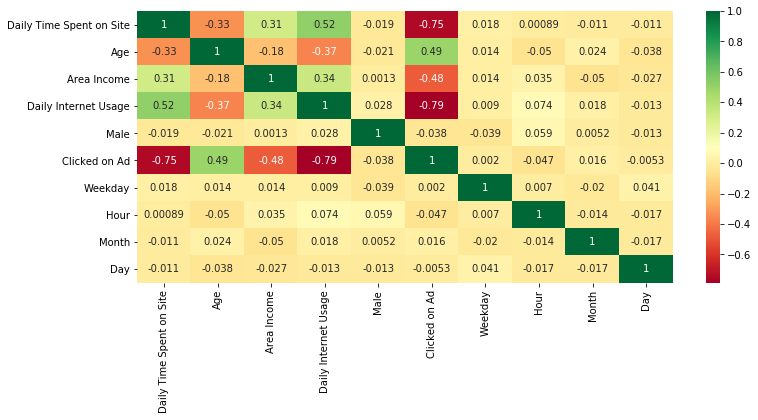

<IPython.core.display.Javascript object>

In [15]:
plt.figure(figsize=(12, 5))
sns.heatmap(ad_df.corr(), cmap="RdYlGn", annot=True)
plt.show()

None of the new features have good correlation with the label and the other features. 

We can drop them or we can keep them for a more accurate model.

### Data Pre-processing

We'll scale our numeric variables and encode our cateforical variable.

### Modeling

### Model Analysis

### Conclusion